<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(2021_12_13).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第10回）**##

（執筆中）
時系列観測データから、数理モデルのパラメータをベイズ推定


Sequential MonteCarlo (SMC);
Approximated Bayesian Computation (ABC);

パラメータ値$\theta$を入れてシミュレーションする。とにかくたくさんやる。データ$y$に近いところだけ集めてきて、いい感じに、パラメータ値の事後分布$p(\theta|y)$を作る。計算機の力で押し切る。

**解説**

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

In [2]:
from scipy.integrate import odeint

# ロトカ・ボルテラ方程式

# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10.0, 5.0]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(X, t, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """

    return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * b * X[0] * X[1]])


# simulator function
def competition_model(a, b, c,d):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(a, b, c, d))

In [3]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(a, b, c, d) + noise
    return simulated

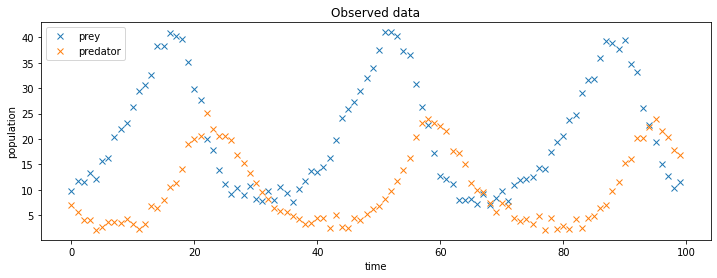

In [4]:
# plotting observed data.
observed = add_noise(a, b, c, d)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(observed[:, 0], "x", label="prey")
ax.plot(observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();

In [5]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.0) ##非負値
    b = pm.HalfNormal("b", 1.0) ##非負値
    c = pm.HalfNormal("c", 1.0) ##非負値
    d = pm.HalfNormal("d", 1.0) ##非負値

    sim = pm.Simulator("sim", competition_model, params=(a, b, c, d), epsilon=10, observed=observed)

    trace_lv = pm.sample_smc(kernel="ABC", parallel=True)
    idata_lv = az.from_pymc3(trace_lv)

Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 0.010
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/pymc3/distributions/simulator.py:146: RuntimeWarning: overflow encountered in square
  return -0.5 * ((obs_data - sim_data) / epsilon) ** 2
Stage:   1 Beta: 0.019
Stage:   2 Beta: 0.030
Stage:   3 Beta: 0.051
Stage:   4 Beta: 0.106
Stage:   5 Beta: 0.232
Stage:   6 Beta: 0.514
Stage:   7 Beta: 1.000
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcb5178510>,
      dtype=object)

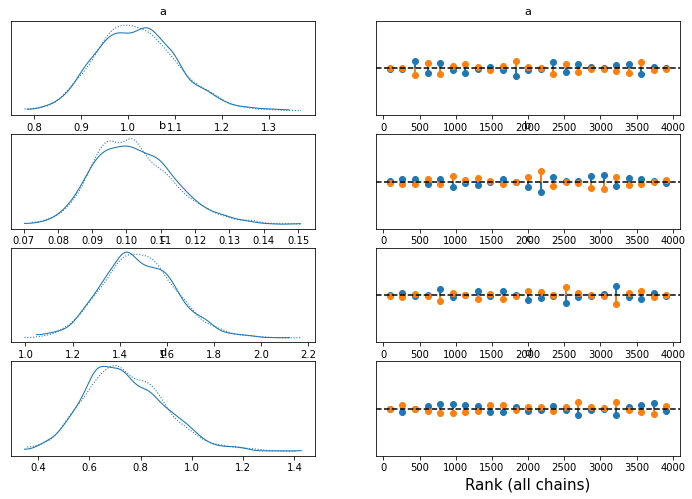

In [6]:
az.plot_trace(idata_lv, kind="rank_vlines")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcac630090>,
      dtype=object)

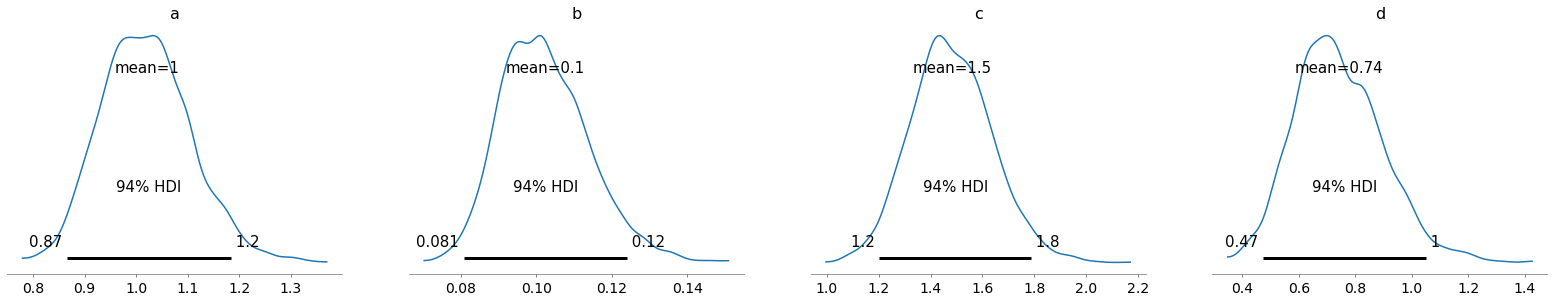

In [7]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata_lv)

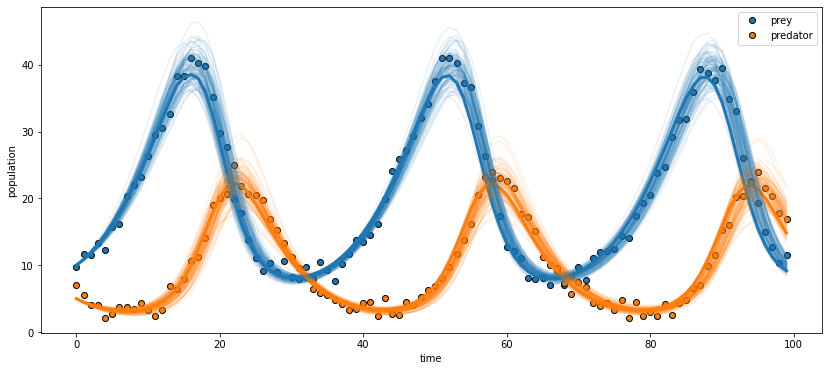

In [8]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")
ax.plot(competition_model(trace_lv["a"].mean(), trace_lv["b"].mean(), trace_lv["c"].mean(), trace_lv["d"].mean()), linewidth=3)
for i in np.random.randint(0, len(trace_lv), 100):
    sim = competition_model(trace_lv["a"][i], trace_lv["b"][i], trace_lv["c"][i], trace_lv["d"][i])
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

In [9]:
print("a",trace_lv["a"].mean())
print("b",trace_lv["b"].mean())
print("c",trace_lv["c"].mean())
print("d",trace_lv["d"].mean())

a 1.0203638577058614
b 0.10234321797217545
c 1.4823148037440206
d 0.7415830510208529


##**非線形フィッティング**##

京都の月平均気温の時系列を次の関数形でフィッティングする。
$$
Temp(t) = A\sin(\omega t + \phi) + B_0 + B_1t
$$

講義用の演習データは下記からダウンロード<br>
https://www.dropbox.com/s/90of8k0gtm0nu0s/kyoto_data.csv?dl=1


最新のデータは、気象庁から直接ダウンロードできるので、それで試しても良いです。<br>
https://www.data.jma.go.jp/gmd/risk/obsdl/index.php

In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pandas as pd
import math

In [11]:
df_o = pd.read_csv('kyoto_data.csv',encoding='SHIFT-JIS', skiprows=[0,1,2,3,4], names=['ym','temperature','q','f'])

In [12]:
df=df_o.drop(['q','f'],axis=1)

In [13]:
df['order']=np.linspace(0,df['ym'].shape[0]-1,df['ym'].shape[0])

In [14]:
df

,ym,temperature,order
0,1990/11,13.7,0.0
1,1990/12,7.7,1.0
2,1991/1,5.1,2.0
3,1991/2,4.3,3.0
4,1991/3,9.4,4.0
...,...,...,...
368,2021/7,27.9,368.0
369,2021/8,27.7,369.0
370,2021/9,24.6,370.0
371,2021/10,19.6,371.0


In [15]:
data_x = df.order.values
data_y = df.temperature.values

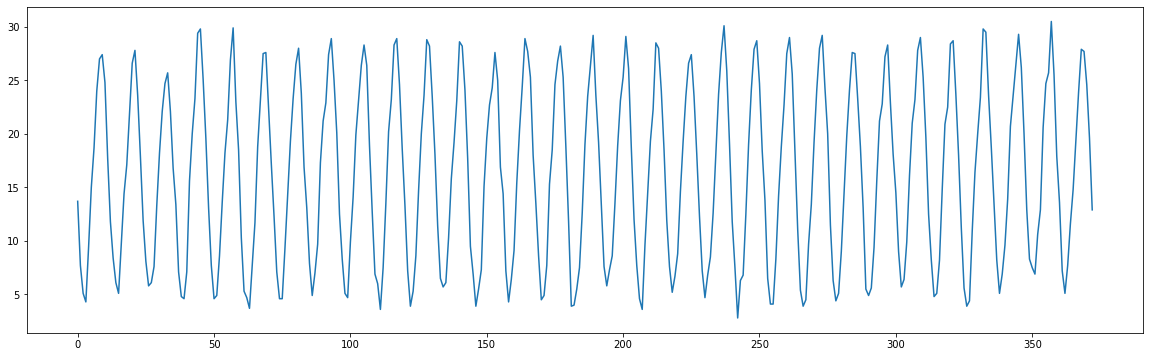

In [16]:
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, label="data", c="C0", mec="k")

周期成分があるので、非線形フィッティングを行う必要がある。
まず、1次多項式による線形フィッティングを行い、直線成分と周期成分に分ける。

In [17]:
from statsmodels.graphics.api import qqplot
import statsmodels.formula.api as smf
#先に最小二乗法で直線成分だけフィッティングし、あとで周期部分をSMCで決定する
## 1次
res1 = smf.ols('temperature ~ order', data=df).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9880
Date:                Sun, 05 Dec 2021   Prob (F-statistic):              0.321
Time:                        10:38:33   Log-Likelihood:                -1315.5
No. Observations:                 373   AIC:                             2635.
Df Residuals:                     371   BIC:                             2643.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.4904      0.853     18.161      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


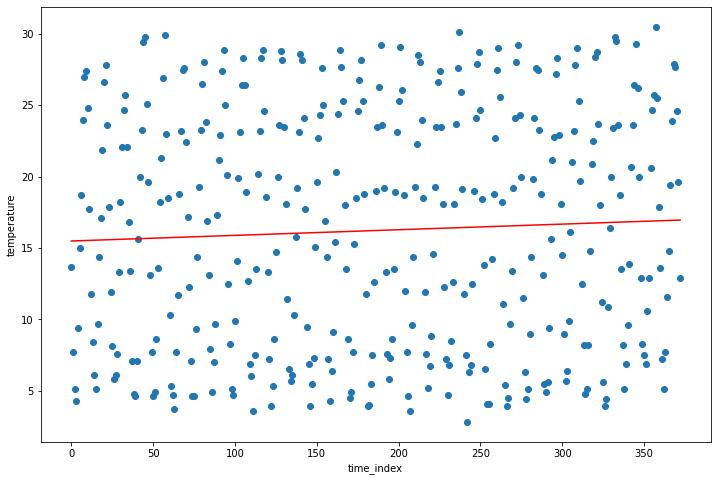

In [18]:
b0, b1 = res1.params

fig = plt.figure(figsize=(12, 8))
plt.scatter(data_x, data_y)
plt.plot(data_x, b0 + b1*data_x, 'r')
plt.xlabel("time_index")
plt.ylabel("temperature")
plt.show()

In [19]:
def siny(a,b,c):
  return a*np.sin(b*data_x + c)+b0+b1*data_x

with pm.Model() as model:
    a = pm.HalfNormal("a", 10) ##非負値
    b = pm.HalfNormal("b", 1) ##非負値
    c = pm.Uniform("c",lower=0, upper=2*math.pi)##範囲[0,2pi]

    sim = pm.Simulator("sim", siny, params=(a,b,c), epsilon=5, observed=data_y)

    trace = pm.sample_smc(kernel="ABC", parallel=True)
    idata = az.from_pymc3(trace)

Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.011
Stage:   2 Beta: 0.016
Stage:   3 Beta: 0.021
Stage:   4 Beta: 0.036
Stage:   5 Beta: 0.091
Stage:   6 Beta: 0.230
Stage:   7 Beta: 0.572
Stage:   8 Beta: 1.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc9ff7fe90>,
      dtype=object)

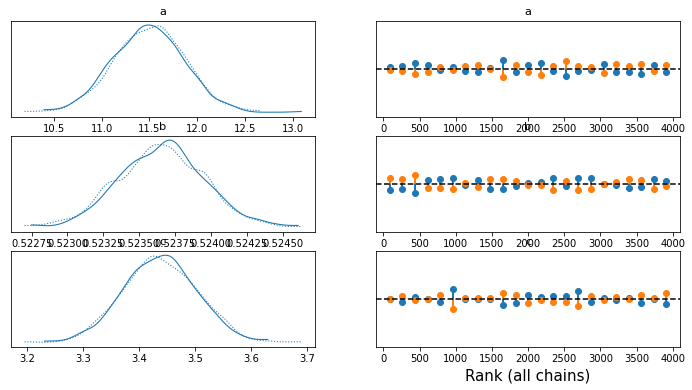

In [20]:
#2つのchainで、事後確率分布は一致している
#colabのcpuでは、chain数は2になるが、もっと良いマシンを使えば、chain数を増やすことが出来る
az.plot_trace(idata, kind="rank_vlines")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc9d5f37d0>,
      dtype=object)

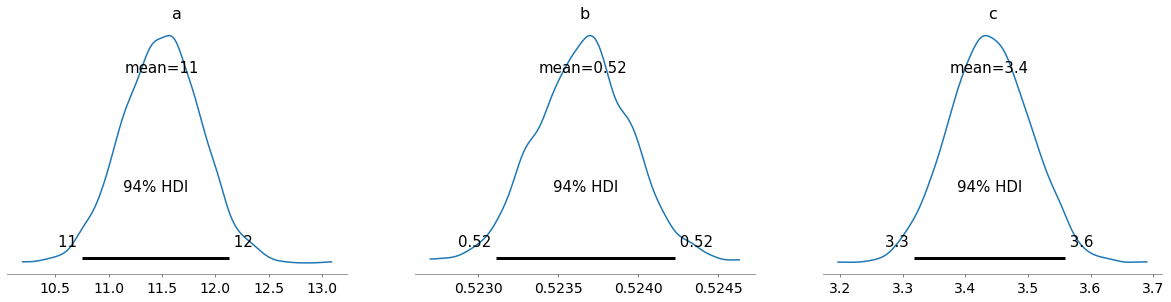

In [21]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata)

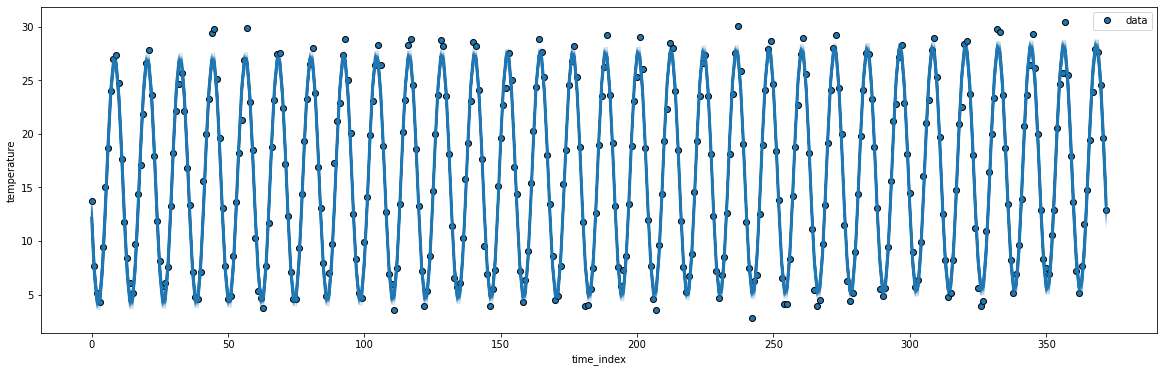

In [22]:
# plot results
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, "o", label="data", c="C0", mec="k")
ax.plot(siny(trace["a"].mean(), trace["b"].mean(), trace["c"].mean()),linewidth=3)
for i in np.random.randint(0, len(trace), 100):
    sim = siny(trace["a"][i], trace["b"][i], trace["c"][i])
    ax.plot(sim, alpha=0.1, c="C0")
ax.set_xlabel("time_index")
ax.set_ylabel("temperature")
ax.legend();

In [23]:
print("a",trace["a"].mean())
print("b",trace["b"].mean())
print("c",trace["c"].mean())
print("b0",b0)
print("b1",b1)

a 11.49460721193807
b 0.5236551939817645
c 3.438286276027276
b0 15.490401571303655
b1 0.003944769435609833


###**非線形最適化法 Basin-hoppingとの比較**###

In [24]:
from scipy.optimize import least_squares
from scipy.optimize import basinhopping

In [25]:
def y(t,theta):
    return theta[0]*np.sin(theta[1]*t + theta[2])+theta[3]+theta[4]*t

In [26]:
def calc_residuals(params, data_x, data_y):
    model_y = y(data_x, params)
    return model_y - data_y

In [27]:
def calc_cost(params, data_x, data_y):
    residuals = calc_residuals(params, data_x, data_y)
    return (residuals * residuals).sum()

In [28]:
a_init = [1,1,1,1,1]
minimizer_kwargs = {"args":(data_x, data_y)}
#basinhoppingはoptimize.minimize()を呼んでいるので、minimizerのdefaultはBFGS
res = basinhopping(calc_cost, a_init,stepsize=0.5,minimizer_kwargs=minimizer_kwargs,niter=200)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [29]:
res

                        fun: 557.5023231373586
 lowest_optimization_result:       fun: 557.5023231373586
 hess_inv: array([[ 2.66415435e-03,  4.14995177e-08, -2.68625031e-06,
         2.02648695e-04, -1.17793420e-06],
       [ 4.14995177e-08,  1.98196150e-09, -3.59317172e-07,
         1.75091795e-07, -1.49830105e-09],
       [-2.68625031e-06, -3.59317172e-07,  8.67639093e-05,
        -1.27131951e-05,  1.32333835e-07],
       [ 2.02648695e-04,  1.75091795e-07, -1.27131951e-05,
         5.85099811e-03, -2.37392376e-05],
       [-1.17793420e-06, -1.49830105e-09,  1.32333835e-07,
        -2.37392376e-05,  1.28817233e-07]])
      jac: array([-2.62451172e-03,  1.32630768e+01,  4.06646729e-02, -1.78527832e-03,
        6.34307861e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 690
      nit: 17
     njev: 97
   status: 2
  success: False
        x: array([ 1.15275463e+01, -5.23657411e-01, -6.94106312e+01,  1.58271711e+01,
        2.18633808e-03])
   

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  func(*args, **kwargs)


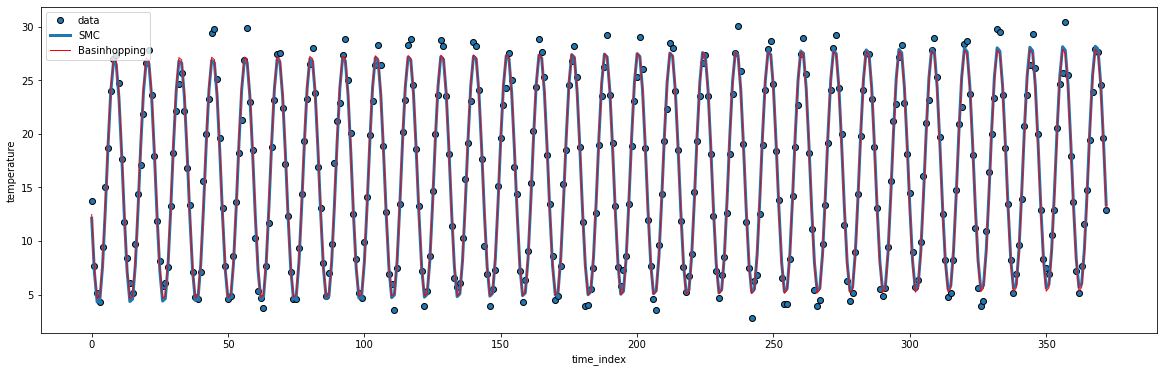

In [30]:
a_fit = res.x
ys_fit = y(data_x,a_fit)

# plot results
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, "o", label="data", c="C0", mec="k")
ax.plot(siny(trace["a"].mean(), trace["b"].mean(), trace["c"].mean()), label="SMC", linewidth=3)
ax.plot(ys_fit,label="Basinhopping", c="R",linewidth=1)

ax.set_xlabel("time_index")
ax.set_ylabel("temperature")
ax.legend();

In [31]:
res.x

array([ 1.15275463e+01, -5.23657411e-01, -6.94106312e+01,  1.58271711e+01,
        2.18633808e-03])